In [12]:
#import packages
import pandas as pd
import numpy as np
import sys
import csv
import re
import seaborn as sns
import string
from tqdm import tqdm
#import natural language toolkit
import nltk
tqdm.pandas()

# download stopwords & punkt
nltk.download('stopwords')
nltk.download('punkt')
nltk.downloader.download('vader_lexicon')

#standardize plot size and font size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams.update({'font.size': 14})

#import natural language processing related functions 
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer 



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owen\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Owen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data Cleaning

In [15]:
df = pd.read_csv('../data/full_dataset.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.drop_duplicates()

In [16]:
df = df.drop_duplicates()

,category,resume,job_title
0,data science,Skills * Programming Languages: Python (pandas...,NaN
1,data science,Education Details \r\nMay 2013 to May 2017 B.E...,NaN
2,data science,"Areas of Interest Deep Learning, Control Syste...",NaN
3,data science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,NaN
4,data science,"Education Details \r\n MCA YMCAUST, Faridab...",NaN
...,...,...,...
3953,automobile,GENERAL LIABILITY CLAIM REPRESENTATIVE\r\nSumm...,NaN
3954,automobile,AUTOMOBILE TRANSPORTER\r\nProfessional Summary...,NaN
3955,automobile,"Highlights\r\n\r\nProg. Languages: C (5+ yrs),...",NaN
3956,automobile,CUSTOMER RELATIONS SPECIALIST\r\nSummary\r\n\r...,NaN


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'sales'),
  Text(1, 0, 'hr'),
  Text(2, 0, 'arts'),
  Text(3, 0, 'advocate'),
  Text(4, 0, 'information-technology'),
  Text(5, 0, 'business-development'),
  Text(6, 0, 'chef'),
  Text(7, 0, 'engineering'),
  Text(8, 0, 'finance'),
  Text(9, 0, 'accountant'),
  Text(10, 0, 'aviation'),
  Text(11, 0, 'fitness'),
  Text(12, 0, 'healthcare'),
  Text(13, 0, 'banking'),
  Text(14, 0, 'consultant')])

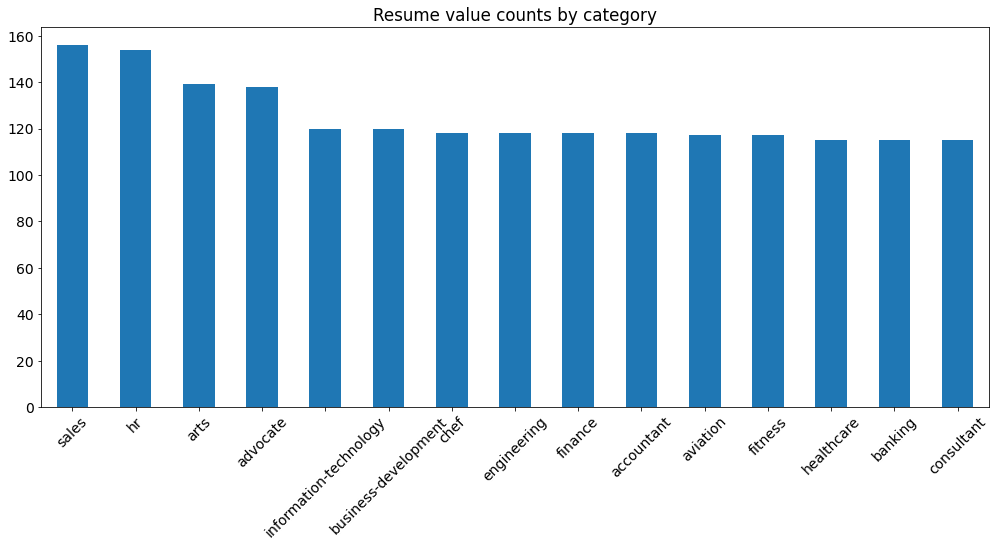

In [22]:
df['category'].value_counts()[:15].plot.bar()
plt.title('Resume value counts by category')
plt.xticks(rotation=45)

### Word Frequency

In [36]:
#lower case all words
df['resume'] = df['resume'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#remove special characters in content
df['resume'] = df['resume'].str.replace(r"[^a-zA-Z\d\_\s]", "")

#tokenize words 
tokenized = df.assign(tokenized_content = df['resume'].apply(nltk.word_tokenize))

# import stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#filter out stopwords in the content column
tokenized['tokenized_content'] = tokenized['tokenized_content'].apply(lambda x: [item for item in x if item not in stop_words] )

#Reducing all words into their root words
from nltk.stem import PorterStemmer
ps = PorterStemmer()
tokenized['tokenized_content'] = tokenized['tokenized_content'].apply(lambda x: [ps.stem(y) for y in x])

#Stack up words appeared in the tokenized content column
most_1 = np.hstack(tokenized['tokenized_content'])

<ipython-input-36-b1e01f1134be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['resume'] = df['resume'].apply(lambda x: " ".join(x.lower() for x in x.split()))
<ipython-input-36-b1e01f1134be>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['resume'] = df['resume'].str.replace(r"[^a-zA-Z\d\_\s]", "")
<ipython-input-36-b1e01f1134be>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['resume'] = df['resume'].str.replace(r"[^a-zA-Z\d\_\s]", "")


In [39]:
most_1 = np.hstack(tokenized['tokenized_content'])

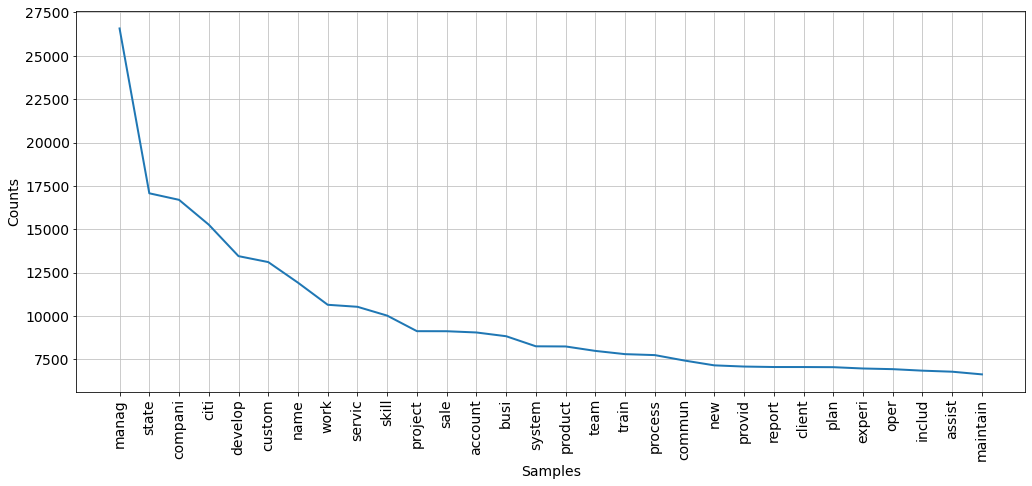

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [40]:
# calculate word frequency
fdist_most = FreqDist(most_1)

for punc in list(string.punctuation)+['``',"''","'s", "“", "”", "’", "--"]:
    del fdist_most[punc]

#plot 30 most frequent words appeared in media articles
fdist_most.plot(30, cumulative=False)


# ner using spacy

In [77]:
import spacy
from spacy import displacy

ner = spacy.load("en_core_web_lg")

In [58]:
# reimport the df
df = pd.read_csv('../data/full_dataset.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.drop_duplicates()

In [126]:
text1 = ner(df['splitted_w_next_line'].iloc[2][0])
for word in text1.ents:
    print(word.text, word.label_)

Control System Design ORG
Electric Machinery ORG
Hindustan Aeronautics Limited ORG
Bangalore GPE
4 weeks DATE
Satish PERSON
Mirage ORG
Python ORG
Java ORG
LabView ORG
Python ORG
Flask FAC
Github PERSON
Jupyter Notebook PERSON
Xampp ORG
MySQL-Basics ORG
Pycharm ORG
Java IDE-Eclipse Operating Systems Windows ORG
Debian-Kali PERSON


In [73]:
df['splitted_w_next_line'] = df['resume'].str.split('\r\n')
df

,category,resume,job_title,splitted_w_next_line
0,data science,Skills * Programming Languages: Python (pandas...,NaN,[Skills * Programming Languages: Python (panda...
1,data science,Education Details \r\nMay 2013 to May 2017 B.E...,NaN,"[Education Details , May 2013 to May 2017 B.E ..."
2,data science,"Areas of Interest Deep Learning, Control Syste...",NaN,"[Areas of Interest Deep Learning, Control Syst..."
3,data science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,NaN,[Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tabl...
4,data science,"Education Details \r\n MCA YMCAUST, Faridab...",NaN,"[Education Details , MCA YMCAUST, Faridaba..."
...,...,...,...,...
3953,automobile,GENERAL LIABILITY CLAIM REPRESENTATIVE\r\nSumm...,NaN,"[GENERAL LIABILITY CLAIM REPRESENTATIVE, Summa..."
3954,automobile,AUTOMOBILE TRANSPORTER\r\nProfessional Summary...,NaN,"[AUTOMOBILE TRANSPORTER, Professional Summary,..."
3955,automobile,"Highlights\r\n\r\nProg. Languages: C (5+ yrs),...",NaN,"[Highlights, , Prog. Languages: C (5+ yrs), Py..."
3956,automobile,CUSTOMER RELATIONS SPECIALIST\r\nSummary\r\n\r...,NaN,"[CUSTOMER RELATIONS SPECIALIST, Summary, , To ..."


In [94]:
def count_entity(x):
    dic = {}
    for elem in x:
        text1 = ner(elem)
        for word in text1.ents:
            if word.label_ in dic.keys():
                dic[word.label_] += 1
            else:
                dic[word.label_] = 1
    return dic

In [97]:
df['entity_dic'] = df['splitted_w_next_line'].progress_apply(count_entity)

100%|██████████████████████████████████████████████████████████████████████████████| 3148/3148 [17:13<00:00,  3.05it/s]


In [98]:
df

,category,resume,job_title,splitted_w_next_line,entity_dic
0,data science,Skills * Programming Languages: Python (pandas...,NaN,[Skills * Programming Languages: Python (panda...,"{'NORP': 1, 'ORG': 41, 'PRODUCT': 1, 'PERSON':..."
1,data science,Education Details \r\nMay 2013 to May 2017 B.E...,NaN,"[Education Details , May 2013 to May 2017 B.E ...","{'DATE': 2, 'ORG': 6, 'GPE': 5, 'CARDINAL': 1,..."
2,data science,"Areas of Interest Deep Learning, Control Syste...",NaN,"[Areas of Interest Deep Learning, Control Syst...","{'ORG': 18, 'GPE': 8, 'DATE': 5, 'PERSON': 4, ..."
3,data science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,NaN,[Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tabl...,"{'PERSON': 9, 'ORG': 64, 'DATE': 11, 'GPE': 7,..."
4,data science,"Education Details \r\n MCA YMCAUST, Faridab...",NaN,"[Education Details , MCA YMCAUST, Faridaba...","{'ORG': 3, 'GPE': 4}"
...,...,...,...,...,...
3953,automobile,GENERAL LIABILITY CLAIM REPRESENTATIVE\r\nSumm...,NaN,"[GENERAL LIABILITY CLAIM REPRESENTATIVE, Summa...","{'DATE': 1, 'CARDINAL': 5, 'ORG': 10, 'MONEY': 1}"
3954,automobile,AUTOMOBILE TRANSPORTER\r\nProfessional Summary...,NaN,"[AUTOMOBILE TRANSPORTER, Professional Summary,...","{'DATE': 16, 'ORG': 13, 'CARDINAL': 4, 'GPE': ..."
3955,automobile,"Highlights\r\n\r\nProg. Languages: C (5+ yrs),...",NaN,"[Highlights, , Prog. Languages: C (5+ yrs), Py...","{'DATE': 18, 'ORG': 67, 'CARDINAL': 2, 'PERSON..."
3956,automobile,CUSTOMER RELATIONS SPECIALIST\r\nSummary\r\n\r...,NaN,"[CUSTOMER RELATIONS SPECIALIST, Summary, , To ...","{'ORG': 14, 'DATE': 13, 'PERSON': 2, 'TIME': 2..."


In [100]:
dic = {}
for row in tqdm(df['entity_dic']):
    for key in row:
        if key in dic.keys():
            dic[key] += row[key]
        else:
            dic[key] = row[key]
    

100%|██████████████████████████████████████████████████████████████████████████| 3148/3148 [00:00<00:00, 314822.82it/s]


In [112]:
freq_ent = pd.DataFrame(data = dic, index=[0]).T.reset_index().rename(columns = {'index':'entity_type', 0:'frequency'})
freq_ent['entity_detail'] = freq_ent['entity_type'].apply(lambda x: spacy.explain(x))

In [121]:
freq_ent.sort_values('frequency', ascending=False)[['entity_type','entity_detail','frequency']]

,entity_type,entity_detail,frequency
1,ORG,"Companies, agencies, institutions, etc.",96501
4,DATE,Absolute or relative dates or periods,33545
6,CARDINAL,Numerals that do not fall under another type,19608
5,GPE,"Countries, cities, states",15293
3,PERSON,"People, including fictional",8204
2,PRODUCT,"Objects, vehicles, foods, etc. (not services)",3274
16,MONEY,"Monetary values, including unit",2583
10,PERCENT,"Percentage, including ""%""",2577
0,NORP,Nationalities or religious or political groups,1854
11,ORDINAL,"""first"", ""second"", etc.",1398


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'ORG'),
  Text(1, 0, 'DATE'),
  Text(2, 0, 'CARDINAL'),
  Text(3, 0, 'GPE'),
  Text(4, 0, 'PERSON'),
  Text(5, 0, 'PRODUCT'),
  Text(6, 0, 'MONEY'),
  Text(7, 0, 'PERCENT'),
  Text(8, 0, 'NORP'),
  Text(9, 0, 'ORDINAL'),
  Text(10, 0, 'WORK_OF_ART'),
  Text(11, 0, 'LANGUAGE'),
  Text(12, 0, 'TIME'),
  Text(13, 0, 'LOC'),
  Text(14, 0, 'FAC'),
  Text(15, 0, 'LAW'),
  Text(16, 0, 'EVENT'),
  Text(17, 0, 'QUANTITY')])

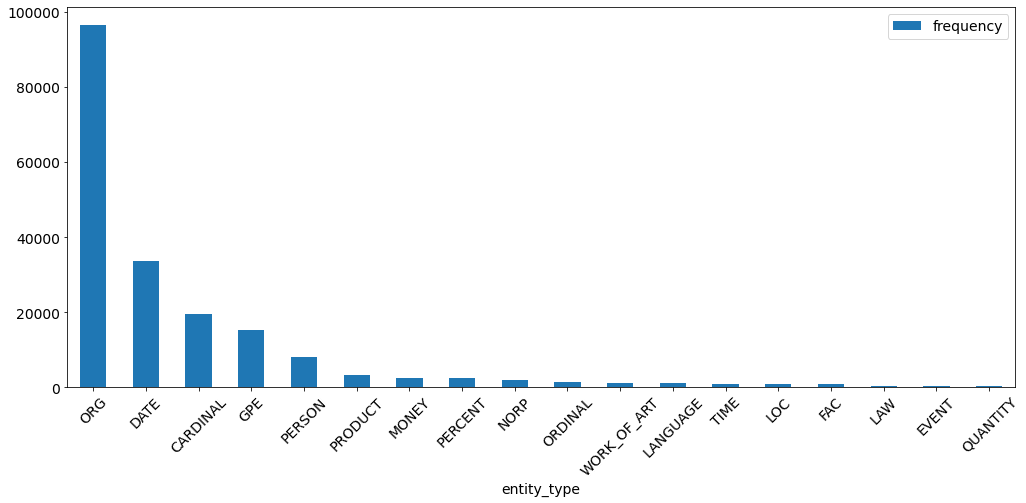

In [118]:
freq_ent.sort_values('frequency', ascending=False)[['entity_type', 'frequency']].set_index('entity_type').plot.bar()
plt.xticks(rotation=45)

In [124]:
freq_ent.frequency.sum()

190872